# Nonlinear equations
### (with Giovanni Stabile)

The implementations are not performant, nor beautiful, and they probably use a lot of anti-patterns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

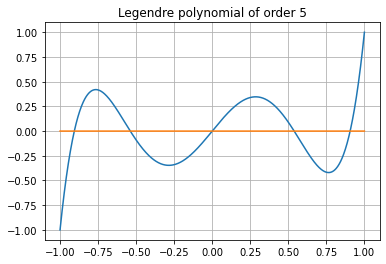

In [2]:
t = sym.symbols('t')

f_sym = t/8. * (63.*t**4 - 70.*t**2. +15.)
f_prime_sym = sym.diff(f_sym,t)

f = sym.lambdify(t, f_sym, 'numpy')
f_prime = sym.lambdify(t,f_prime_sym, 'numpy')

# Let's plot
n = 1025

x = np.linspace(-1,1,n)
c = np.zeros_like(x)

plt.plot(x,f(x))
plt.plot(x,c)
plt.grid()
plt.title('Legendre polynomial of order 5')
plt.show();

In [17]:
# interval in which we look for a zero
a = 0.7
b = 1

x0 = (a+b) / 2

# tolerance
eps = 1.e-10
# maximum number of iterations
n_max = 1000

In [9]:
def error_and_function(x,f,x0,progressive_error):
    iterations = np.array(range(1,len(progressive_error)+1))

    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(iterations, progressive_error, 'ro-')
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(x, f(x))
    plt.plot(x,c)
    plt.scatter([x0], [f(x0)])
    plt.grid()

    plt.show();

## Bisection method
The iterative scheme is defined as follows:
$$x_{k+1} = \frac{a_{k} + b_{k}}{2}$$
where $a_k = \begin{cases}a_{k-1} &\text{if } f(a_{k-1})f(x_k) < 0\\ x_k &\text{otherwise}\end{cases}$ and $b_k = \begin{cases}b_{k-1} &\text{if } f(b_{k-1})f(x_k) < 0\\ x_k &\text{otherwise}\end{cases}$

We look for a root of the function in the interval $[a,b]$ defined below. We also define several parameters which are then used by the bisection method:

In [4]:
def bisect(f,a,b,eps,n_max):
    fa = f(a)
    fb = f(b)
    
    if fa*fb > 0:
        raise ValueError('f(a)f(b) must be negative')
    
    x = (a+b)/2
    
    progressive_error = []
    
    for _ in range(n_max):
        fx = f(x)
        
        progressive_error.append(np.abs(fx))
        
        if np.abs(fx) < eps:
            return x, progressive_error
        
        if fa*fx < 0:
            b = x
            fb = fx
        else:
            a = x
            fa = fx
            
        x = (a+b)/2
            
    return x, progressive_error

approximate solution: 0.9061798459501006, f(0.9061798459501006) = 7.857261621871514e-11


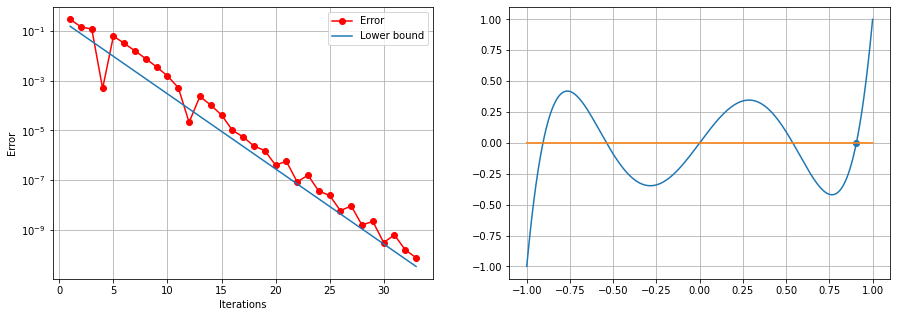

In [18]:
x0, error = bisect(f,a,b,eps,1000)
print('approximate solution: {}, f({}) = {}'.format(x0, x0, f(x0)))
iterations = np.array(range(1,len(error)+1))

def expected_upper_bound(a,b,iterations):
    return (b-a) / np.power(2,iterations)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(iterations, error, 'ro-', label='Error')
plt.plot(iterations, expected_upper_bound(a,b,iterations), label='Lower bound')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(x, f(x))
plt.plot(x,c)
plt.grid()
plt.scatter([x0], [f(x0)])

plt.show();

## Newton method
The iterative scheme is derived from Tayor expansion (stopped at the first term), and has the following form:
$$x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}$$

Notice that we are computing the derivative at each iteration, which is costly in terms of performance.

In [22]:
def general_newton_method(f, q, x0, eps, n_max):
    progressive_error = []
    
    x = x0
    xold = None
    for _ in range(n_max):
        fx = f(x)
        
        progressive_error.append(np.abs(fx))
        
        if np.abs(fx) < eps:
            return x, progressive_error
        
        temp = x
        x = x - fx / q(x, xold)
        xold = temp
            
    return x, progressive_error

approximate solution: 0.9061798459386645, f(0.9061798459386645) = 4.02424691764953e-15


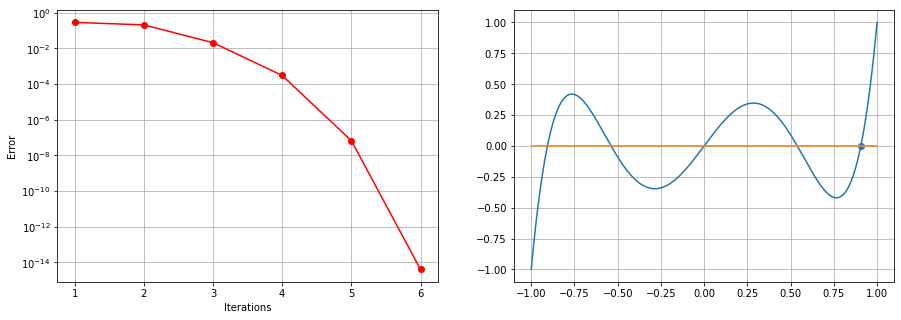

In [20]:
x0, error = general_newton_method(f,f_prime,(a+b)/2,eps,1000)
print('approximate solution: {}, f({}) = {}'.format(x0, x0, f(x0)))

error_and_function(x,f,x0,error)

## Chord method
This is more performant than Newton method since it does not compute the derivative of the function at each step, but instead computes an approximation beforehand:

$$x_{k+1} = x_k - \frac{f(x_k)}{q}$$ with $$q = \frac{f(b) - f(a)}{b-a}$$

approximate solution: 0.9061798459502479, f(0.9061798459502479) = 7.958511674322147e-11


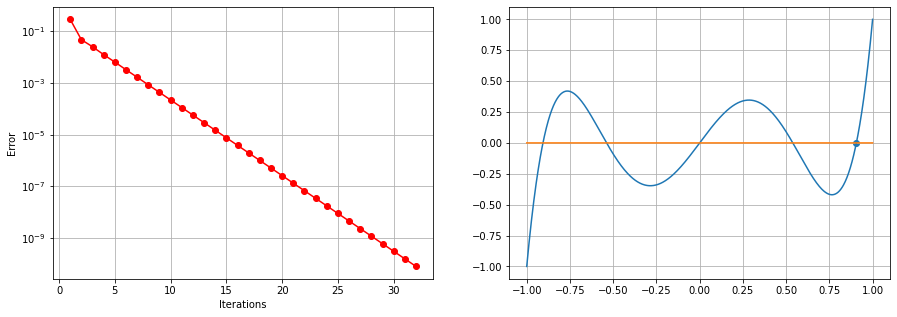

In [23]:
def q(x, xold):
    # ignore x
    return (f(b) - f(a)) / (b-a)

x0, error = general_newton_method(f,q,(a+b)/2,eps,1000)
print('approximate solution: {}, f({}) = {}'.format(x0, x0, f(x0)))

error_and_function(x,f,x0,error)

approximate solution: 0.906179845938664, f(0.906179845938664) = 0.0


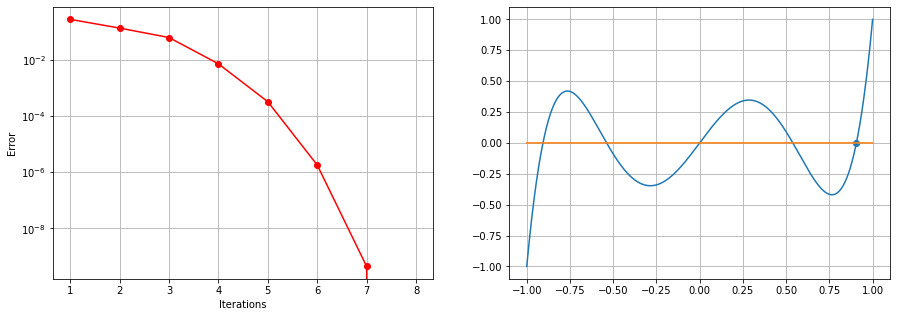

In [26]:
x00 = b

def q(x, xold):
    if xold is None:
        xold = x00
    # ignore x
    return (f(x) - f(xold)) / (x-xold)

x0, error = general_newton_method(f,q,(a+b)/2,eps,1000)
print('approximate solution: {}, f({}) = {}'.format(x0, x0, f(x0)))

error_and_function(x,f,x0,error)

## Fixed point iterations

$x_{k+1} = \phi(x_k)$
If $x$ is a fixed point for $\phi$, this means that $\phi(x) = x$. We want a $\phi$ such that if $f(x) = 0$ then also $x - \phi(x) = 0$.

In [27]:
def fixed_point(phi, x0, eps, n_max):
    progressive_error = []
    
    x = x0
    for _ in range(n_max):
        err = np.abs(phi(x) - x)
        if err < eps:
            return x, progressive_error
        
        progressive_error.append(err)
        
        x = phi(x)
    
    return x, progressive_error

approximate solution: 0.5384693101144257, f(0.5384693101144257) = -2.120853785186162e-11


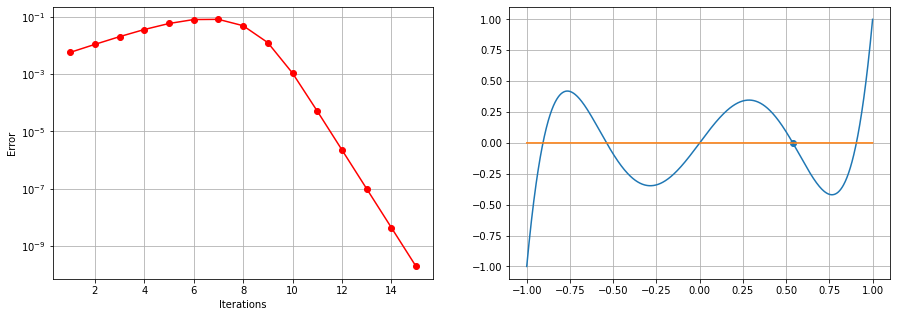

approximate solution: 1.5612230023233282e-19, f(1.5612230023233282e-19) = 2.9272931293562405e-19


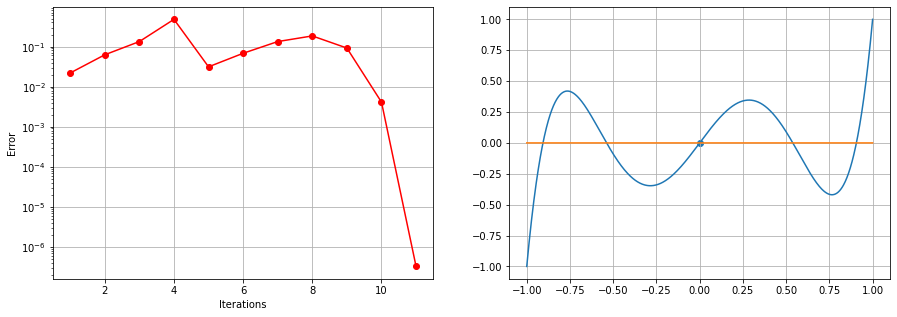

approximate solution: 0.5384693102384218, f(0.5384693102384218) = -3.2200948064641153e-10


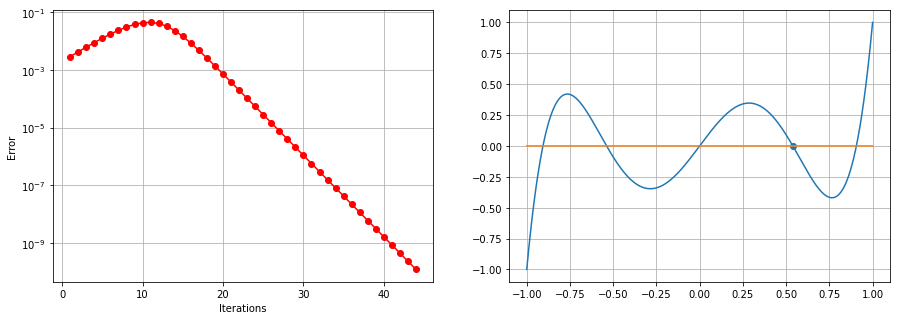

In [33]:
phis = [lambda x : 63./70.*x**3 + 15./(70.*x), 
       lambda x : 70.0/15.0*x**3 - 63.0/15.0*x**5, 
       lambda x : np.sqrt((63.*x**4 + 15.0)/70.)]

for phi in phis:
    x0, error = fixed_point(phi,0.9,eps,1000)
    print('approximate solution: {}, f({}) = {}'.format(x0, x0, f(x0)))

    error_and_function(x,f,x0,error)